# Avito classifier

In this notebook we will try to solve the classification problem in NLP (text classification).

## 1. Dataset

Our dataset includes some ads from Avito. Down below we can see pandas table with 5 columns:

    + item_id - it's just item id )))0); 
    + title - ad's title; 
    + description - good's descriptions (most important data for 
    our problem);
    + price;
    + category_id - our target variable.

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('train.csv')
data.head()

,item_id,title,description,price,category_id
0,0,Картина,Гобелен. Размеры 139х84см.,1000.0,19
1,1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22
2,2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37
3,3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43
4,4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1


## 1.2 Data exploration

In [3]:
import matplotlib.pyplot as plt

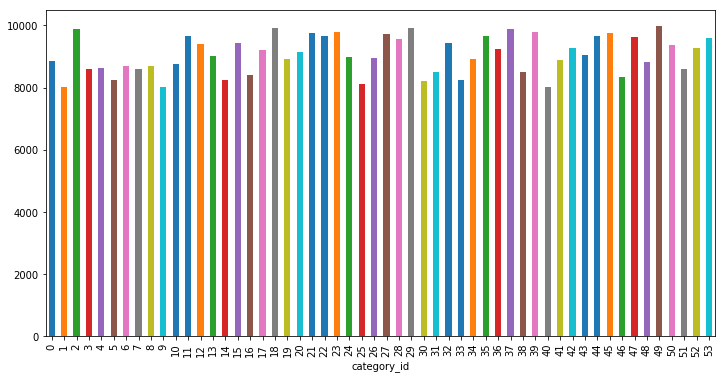

In [4]:
fig = plt.figure(figsize=(12,6))
data.groupby('category_id').description.count().plot.bar(ylim=0)
plt.show()

Here we can see that there is no any 'mortal' imbalance in categories

In [8]:
import numpy as np

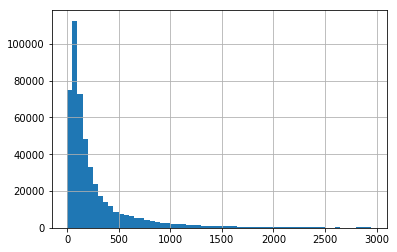

In [9]:
lens = data.description.str.len()
lens.hist(bins = np.arange(0,3000,50))

The distribution of the number of words in advertisements.

Most of the advertisements length are within 100 characters, with some outliers up to 3,000 characters long.

## 1.3 Data preprocessing

Let's join 'title' and 'description' together. It will make our preprocessing and calculations easier. And by the way these features are strongly related, so there is no need to make extra dimension.

In [10]:
data.insert(1 , 'text', data.apply(lambda x: x['title'] + ' ' + x['description'], axis=1))
data.drop(['title', 'description'], axis=1, inplace=True)

data.head()

,item_id,text,price,category_id
0,0,Картина Гобелен. Размеры 139х84см.,1000.0,19
1,1,Стулья из прессованной кожи Продам недорого 4 ...,1250.0,22
2,2,"Домашняя мини баня Мини баня МБ-1(мини сауна),...",13000.0,37
3,3,"Эксклюзивная коллекция книг ""Трансаэро"" + пода...",4000.0,43
4,4,Ноутбук aser Продаётся ноутбук ACER e5-511C2TA...,19000.0,1


Now let's use 'GOOD OLD'regular expressions for cleanup and standard func '.lower()' to make words similar

In [27]:
import re

def del_symb(text):
    #return re.sub(r"[^a-zA-Zа-яёА-Я0-9]", " ", text.lower())
    return re.sub(r"[^a-zA-Zа-яёА-Я]", " ", text.lower())

In [28]:
data['text'] = data['text'].apply(del_symb)

data.head()

,item_id,text,price,category_id
0,0,картина гобелен размеры х см,1000.0,19
1,1,стулья из прессованной кожи продам недорого ...,1250.0,22
2,2,домашняя мини баня мини баня мб мини сауна ...,13000.0,37
3,3,эксклюзивная коллекция книг трансаэро пода...,4000.0,43
4,4,ноутбук aser продаётся ноутбук acer e c ta...,19000.0,1


Before 'hard-core' preprocessing we could count unique word's amount

In [29]:
n_words = len(set(' '.join(data['text']).split()))
n_words

376867

stop_words is set to "russian" to remove all common pronouns ("в", "где", ...) to reduce the number of noisy features.

In [30]:
from nltk.corpus import stopwords
import Stemmer as stm

There're a lot of different specific stop_words like 'продам' and 'товар' in ads, so it's better to add them manually

In [32]:
my_stop_words = ['продам', 'продать',
                 'руб', 'рублей',
                 'тысяч', 'новый',
                 'старый', 'товар', 'товара'
                 'вес', 'длина', 'длинна', 
                 'толщина', 'состояние',
                 'хорошее', 'отличное',
                 'отличный', 'прекрасный',
                 'размер', 'размеры',
                 'цвет', 'мм', 
                 'mm', 'sm',
                 'см', 'кг', 'г',
                 'мг','производитель', 'код',
                 'год', 'года', 'товар','товара',
                 'категория'
                ]

# it is possible to add some more but these are first that comes to my mind.

In [33]:
def process(input_text):
    language = 'russian'
    stemmer = stm.Stemmer(language)
    
    # List of stop words 
    stop_words = stopwords.words(language)+my_stop_words
    # Remove the stop words 
    input_text = [x for x in input_text.split() if not x in stop_words]  
    # Stemming on the words 
    input_text = [stemmer.stemWord(x) for x in input_text]
    
    return ' '.join(input_text)

In [34]:
data['text'] = data['text'].apply(process)

In [35]:
data.head()

,item_id,text,price,category_id
0,0,картин гобел х,1000.0,19
1,1,стул прессова кож недор стул светл прессова ко...,1250.0,22
2,2,домашн мин бан мин бан мб мин саун предназнач ...,13000.0,37
3,3,эксклюзивн коллекц книг трансаэр подарок экскл...,4000.0,43
4,4,ноутбук aser продаёт ноутбук acer e c ta купл ...,19000.0,1


In [36]:
n_words = len(set(' '.join(data['text']).split()))
n_words

200489

We definetly reduced unique word's amount

## 1.4 Tfidf

Specifically, for each term in our dataset, we will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. We will use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of consumer complaint narratives:
   - sublinear_df is set to True to use a logarithmic form for frequency
   - min_df is the minimum numbers of documents a word must be present in to be kept
   - norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1
   - ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams



    

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
# parameters were selected experimentally

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2',
                        ngram_range=(1, 2), max_features=9000)

In [40]:
features = tfidf.fit_transform(data.text)

In [41]:
labels = data.category_id
features.shape

(489517, 9000)

Now, each of 489517 advertisements is represented by 9000 features, representing the tf-idf score for different unigrams and bigrams.

We can use sklearn.feature_selection.chi2 to find the terms that are the most correlated with each of the categories:

In [42]:
data.category_id.unique()

array([19, 22, 37, 43,  1, 50, 41, 36, 48, 39, 30, 34, 46, 28, 24, 17, 32,
       38, 51, 18, 14,  5,  4,  2, 33, 20, 13, 49,  8, 11, 53, 21, 25, 42,
       40, 31, 12, 44, 23,  6,  7,  0, 15, 27, 29, 52,  3,  9, 16, 35, 47,
       45, 26, 10])

In [43]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for category_id in sorted(data.category_id.unique()):
    
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category_id))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# '0':
  . Most correlated unigrams:
. айфон
. iphone
  . Most correlated bigrams:
. прода iphone
. iphone gb
# '1':
  . Most correlated unigrams:
. нетбук
. ноутбук
  . Most correlated bigrams:
. acer aspire
. ноутбук asus
# '2':
  . Most correlated unigrams:
. samsung
. galaxy
  . Most correlated bigrams:
. телефон samsung
. samsung galaxy
# '3':
  . Most correlated unigrams:
. ipad
. планшет
  . Most correlated bigrams:
. galaxy tab
. ipad mini
# '4':
  . Most correlated unigrams:
. приставк
. джойстик
  . Most correlated bigrams:
. игров приставк
. sony playstation
# '5':
  . Most correlated unigrams:
. пульт
. телевизор
  . Most correlated bigrams:
. телевизор lg
. телевизор samsung
# '6':
  . Most correlated unigrams:
. meizu
. highscreen
  . Most correlated bigrams:
. meizu mx
. asus zenfone
# '7':
  . Most correlated unigrams:
. компьютер
. системн
  . Most correlated bigrams:
. материнск плат
. системн блок
# '8':
  . Most correlated unigrams:
. игр
. ps
  . Most correlated bi

As for me, that does make sense

## 2. Classifiers

/home/dimitry/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dimitry/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


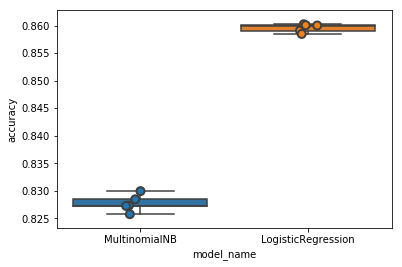

In [45]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    #RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    #LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

## 2.2 LogisticRegression

As we can see, LogisticRegression performs much better than MultinomialNB, so we will try to improve LogisticRegression. 

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels, 
                                                    test_size=0.2, 
                                                    random_state=0)

Create Logistic Regression

In [47]:
# Create logistic regression
logistic = LogisticRegression()

In [67]:
models[1]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

models

In [55]:
# обучаем модель и сохраняем веса (делаем это один раз. дальше просто загружаем веса обученой модели, и предсказываем)
#сохранение весов на диск

from sklearn.externals import joblib

logistic_1 = models[1].fit(X_train, y_train)
joblib.dump(logistic_1, 'logistic_1.pkl') #сохранение весов на диск




/home/dimitry/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dimitry/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [ ]:
logistic_load = joblib.load('logistic_1.pkl') # загружаем веса
y_pred = logistic_load.predict(X_test)

In [56]:
y_pred = logistic_1.predict(X_test)

In [59]:
from sklearn.metrics import accuracy_score


print('Global accuracy: {0:.4f}'.format(accuracy_score(y_test, y_pred)))

Global accuracy: 0.8591
